# Oil Seep Detection 

In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.losses import *

from models import *

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
img_dir = "./train_images_256"
mask_dir = "./train_masks_256"

images = []
masks = []

for filename in os.listdir(img_dir):
    sample_img = cv2.imread(os.path.join(img_dir, filename))
    break

width = int(sample_img.shape[1] * 0.5)
height = int(sample_img.shape[0] * 0.5)

for filename in os.listdir(img_dir):
    img_path = os.path.join(img_dir, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # My laptop does not have a GPU, so I am downsizing the images to speed up training
    img_ds = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)
    images.append(img_ds)
    
    mask_path = os.path.join(mask_dir, filename)
    mask = plt.imread(mask_path)
    
    # My laptop does not have a GPU, so I am downsizing the masks to speed up training
    mask_ds = cv2.resize(mask, (width, height), interpolation = cv2.INTER_AREA)
    masks.append(mask_ds)

images = np.array(images)
masks = np.array(masks)

print(images[0].shape)
print(masks[0].shape)

(128, 128, 3)
(128, 128)


## Preprocess Data 

In [3]:
# Normalizing image intensity
images_process = (images / 255)

masks_process = (np.expand_dims(masks, -1) > 0).astype(np.float64)

## Splitting dataset

In [ ]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(images_process, masks_process, test_size=0.2, random_state=1)

# Test-Val split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

print("Training: {}".format(len(y_train)))
print("Validation: {}".format(len(y_val)))
print("Testing: {}".format(len(y_test)))

In [5]:
batch_size = 8

# we create two instances with the same arguments
data_gen_args = dict(rotation_range=90, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,
                     fill_mode='constant', cval=0,)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(
    X_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

mask_generator = mask_datagen.flow(
    y_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Modeling

In [6]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(tf.cast(t, np.float64) * tf.cast(p, np.float64))
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_function(get_iou_vector, [label, pred > 0.5], tf.float64)
  
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = kb.flatten(y_true)
    y_pred_f = kb.flatten(y_pred)
    
    intersection = kb.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (kb.sum(y_true_f) + kb.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = kb.flatten(y_true)
    y_pred_f = kb.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * kb.sum(intersection) + smooth) / (kb.sum(y_true_f) + kb.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [7]:
model = UXception(images[0].shape)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[my_iou_metric, dice_coef, 'acc'])

## Training

In [8]:
result = model.fit(train_generator, steps_per_epoch=len(X_train)//batch_size, validation_data=(X_val, y_val),
                   validation_steps=len(X_val)//batch_size, epochs=50)

Epoch 1/50
79/79 [==============================] - 182s 2s/step - loss: 1.2385 - my_iou_metric: 4.6821e-04 - dice_coef: 0.0570 - acc: 0.9014 - val_loss: 2.0987 - val_my_iou_metric: 0.0000e+00 - val_dice_coef: 0.0828 - val_acc: 0.7292
Epoch 2/50
79/79 [==============================] - 130s 2s/step - loss: 0.8371 - my_iou_metric: 0.0152 - dice_coef: 0.2485 - acc: 0.9689 - val_loss: 3.5705 - val_my_iou_metric: 0.0000e+00 - val_dice_coef: 0.0440 - val_acc: 0.6723
Epoch 3/50
79/79 [==============================] - 128s 2s/step - loss: 0.6714 - my_iou_metric: 0.0434 - dice_coef: 0.3963 - acc: 0.9735 - val_loss: 1.1032 - val_my_iou_metric: 0.0148 - val_dice_coef: 0.0963 - val_acc: 0.9372
Epoch 4/50
79/79 [==============================] - 127s 2s/step - loss: 0.6014 - my_iou_metric: 0.0450 - dice_coef: 0.4639 - acc: 0.9755 - val_loss: 0.5468 - val_my_iou_metric: 0.0573 - val_dice_coef: 0.5184 - val_acc: 0.9846
Epoch 5/50
79/79 [==============================] - 138s 2s/step - loss: 0.5755 

Epoch 37/50
79/79 [==============================] - 165s 2s/step - loss: 0.4864 - my_iou_metric: 0.1022 - dice_coef: 0.5813 - acc: 0.9754 - val_loss: 0.5777 - val_my_iou_metric: 0.0596 - val_dice_coef: 0.5140 - val_acc: 0.9860
Epoch 38/50
79/79 [==============================] - 150s 2s/step - loss: 0.4643 - my_iou_metric: 0.1212 - dice_coef: 0.5987 - acc: 0.9766 - val_loss: 0.8402 - val_my_iou_metric: 0.0825 - val_dice_coef: 0.3672 - val_acc: 0.9584
Epoch 39/50
79/79 [==============================] - 159s 2s/step - loss: 0.4907 - my_iou_metric: 0.1128 - dice_coef: 0.5747 - acc: 0.9770 - val_loss: 0.4962 - val_my_iou_metric: 0.1118 - val_dice_coef: 0.5853 - val_acc: 0.9860
Epoch 40/50
79/79 [==============================] - 171s 2s/step - loss: 0.4717 - my_iou_metric: 0.1223 - dice_coef: 0.5877 - acc: 0.9783 - val_loss: 0.4934 - val_my_iou_metric: 0.1108 - val_dice_coef: 0.5775 - val_acc: 0.9867
Epoch 41/50
79/79 [==============================] - 174s 2s/step - loss: 0.4446 - my_io

## Evaluate Training Results

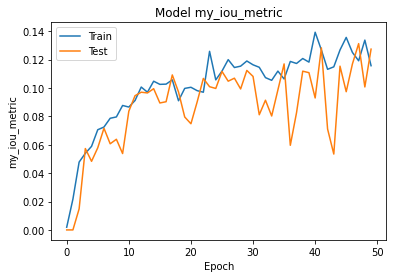

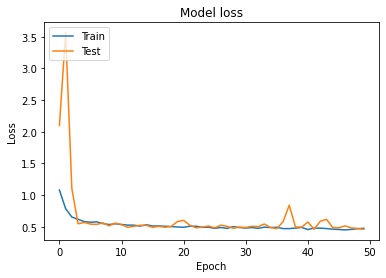

In [9]:
# # Plot training & validation accuracy values
plt.plot(result.history['my_iou_metric'])
plt.plot(result.history['val_my_iou_metric'])
plt.title('Model my_iou_metric')
plt.ylabel('my_iou_metric')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
def plot_test_mask(img, true, pred):
    fig, ax = plt.subplots(1,3, figsize=(12,8))
    
    ax[0].imshow(img)
    ax[0].set_title("Seep Image")

    ax[1].imshow(true)
    ax[1].set_title("Ground Truth")
    
    ax[2].imshow(pred)
    ax[2].set_title("Prediction")

    plt.show()




Sample 0


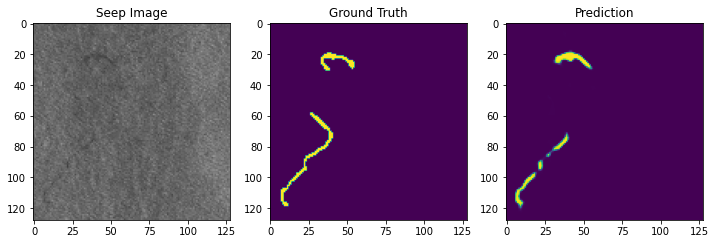




Sample 1


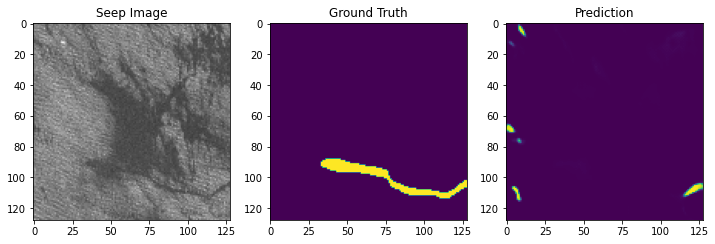




Sample 2


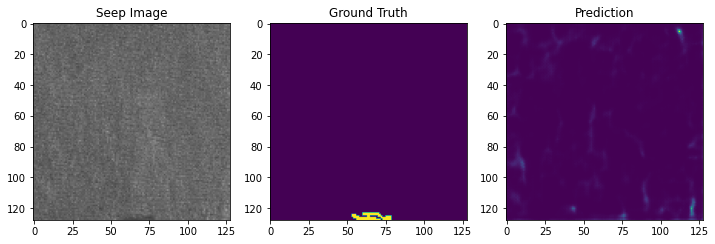




Sample 3


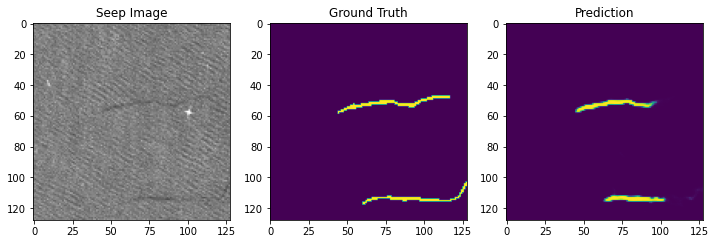




Sample 4


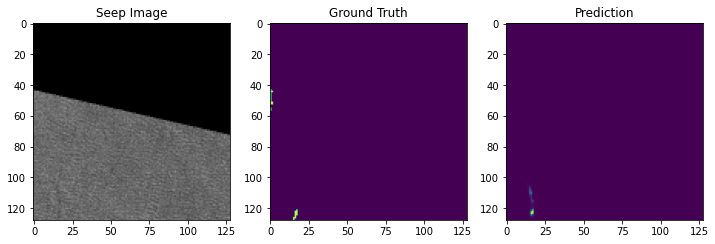




Sample 5


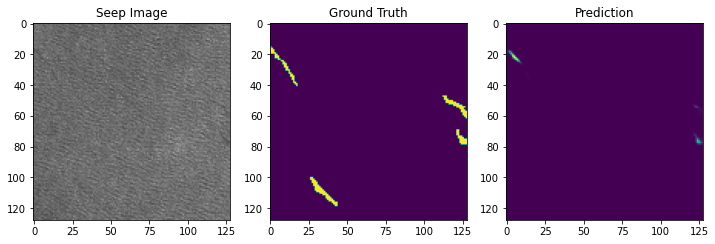




Sample 6


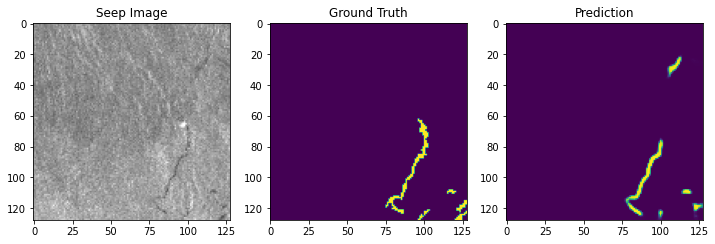




Sample 7


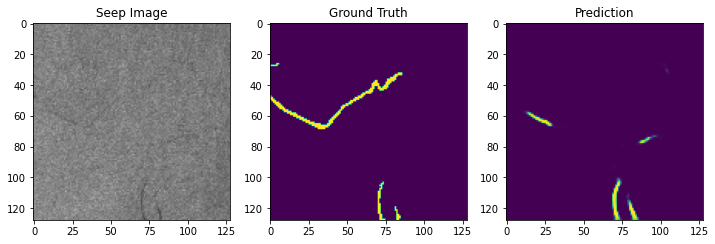




Sample 8


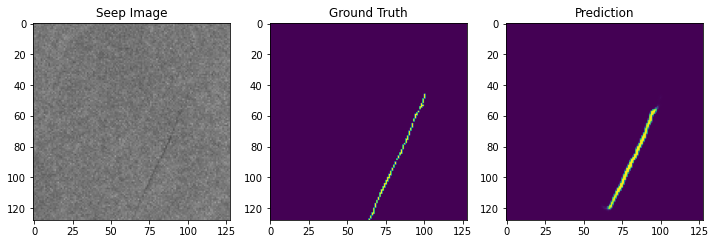




Sample 9


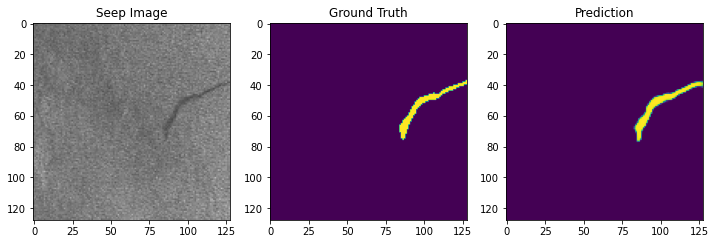




Sample 10


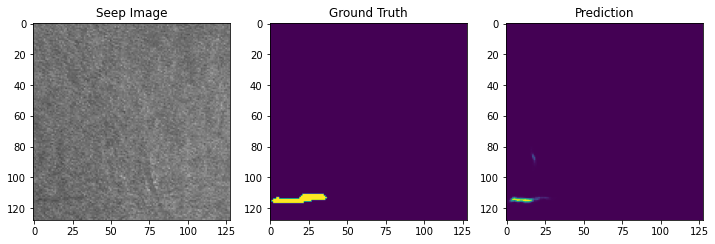




Sample 11


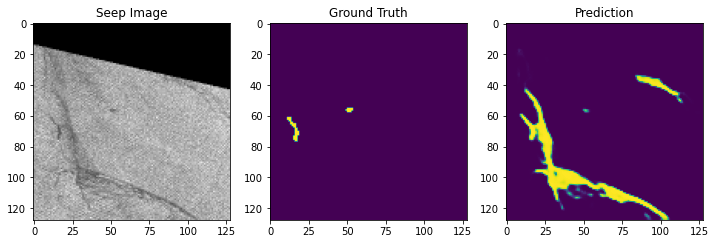




Sample 12


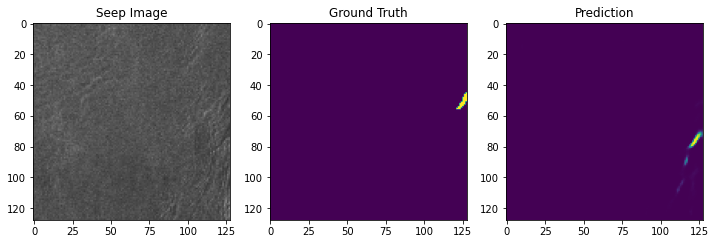




Sample 13


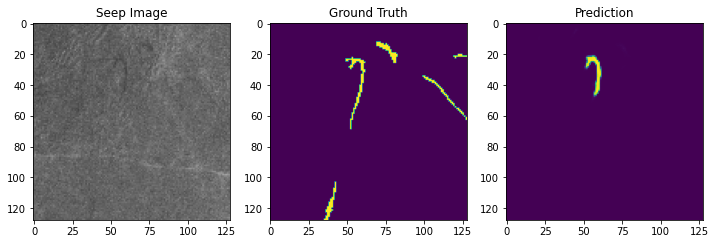




Sample 14


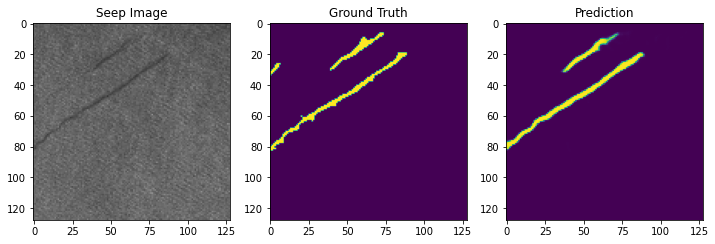




Sample 15


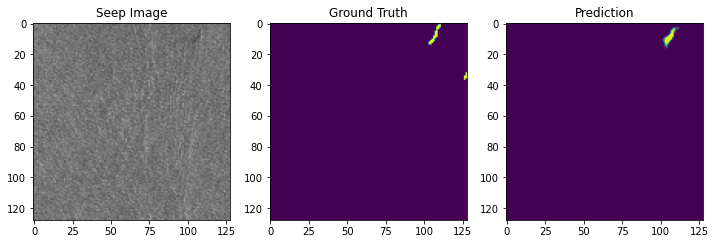




Sample 16


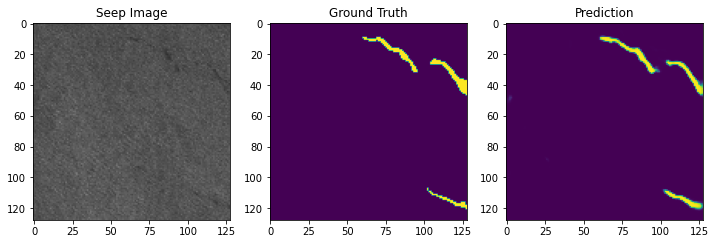




Sample 17


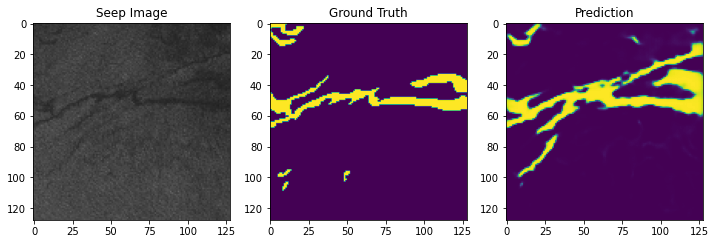




Sample 18


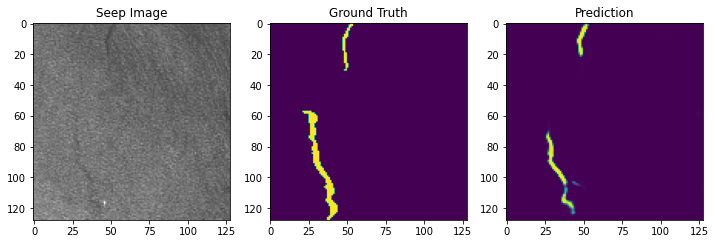




Sample 19


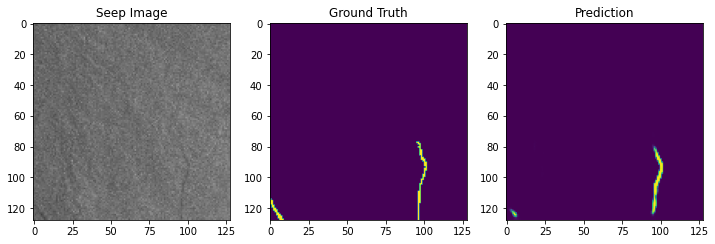




Sample 20


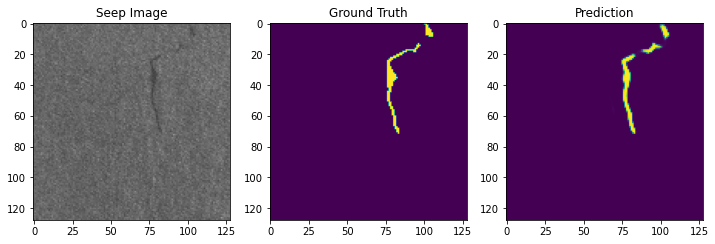




Sample 21


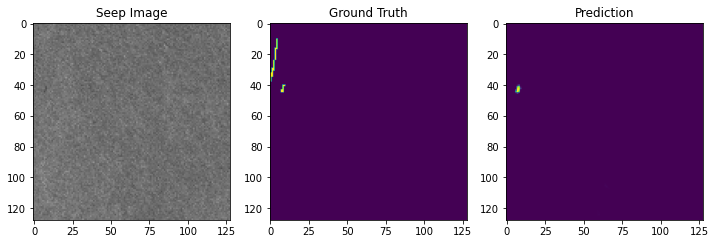




Sample 22


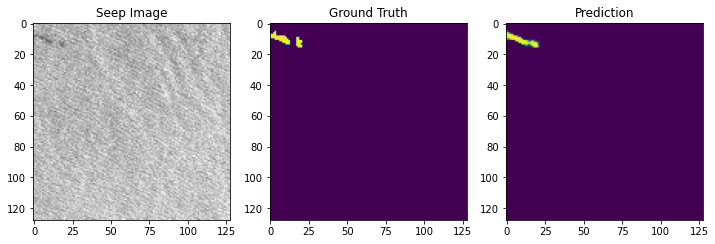




Sample 23


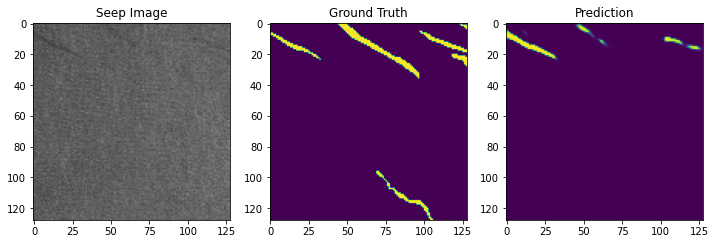




Sample 24


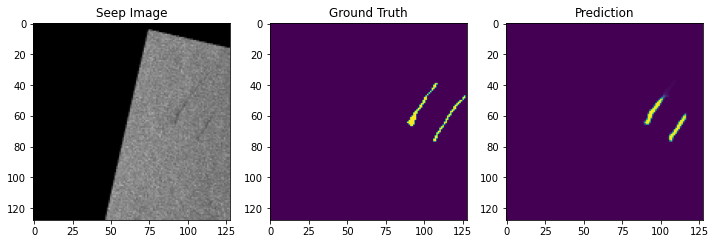




Sample 25


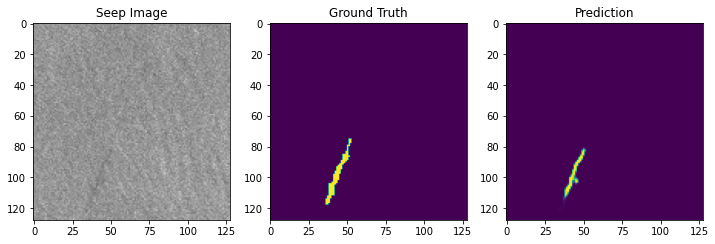




Sample 26


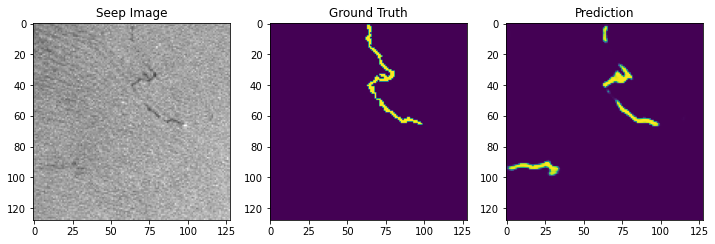




Sample 27


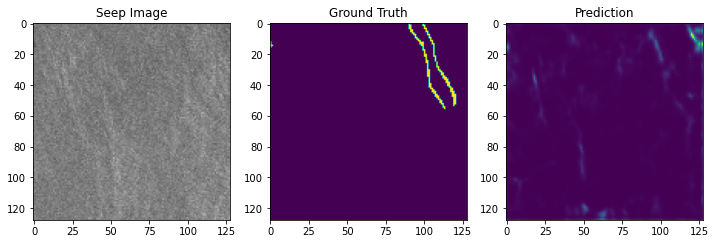




Sample 28


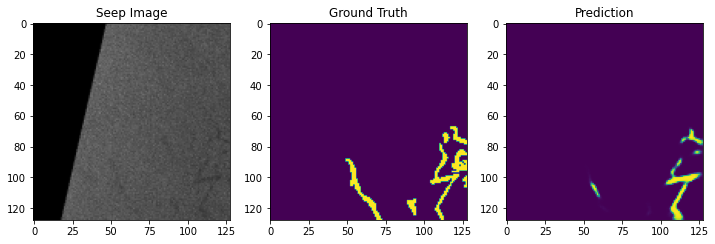




Sample 29


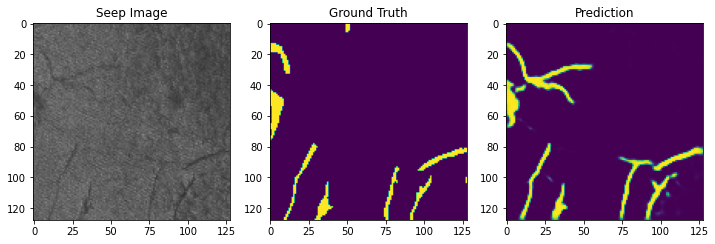

In [11]:
preds = model.predict(X_test)

for idx in range(30):
    print("\n\n\nSample {}".format(idx))
    plot_test_mask(X_test[idx], y_test[idx][:,:,0], preds[idx][:,:,0])


In [12]:
test_loss, test_iou, test_dice_coef, test_acc = model.evaluate(X_test, y_test)

print("\nTest Loss: {}".format(test_loss))
print("Test IoU: {}".format(test_iou))
print("Test Accuracy: {}".format(test_acc))

3/3 [==============================] - 3s 968ms/step - loss: 0.4667 - my_iou_metric: 0.0833 - dice_coef: 0.5935 - acc: 0.9855

Test Loss: 0.4666731059551239
Test IoU: 0.08326388895511627
Test Accuracy: 0.985482931137085
